## Import libraries and data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)

In [3]:
irma = pd.read_csv('../Datasets/florida_irma_2017_2016.csv')
harvey = pd.read_csv('../Datasets/texas_harvey_2017_2016.csv')
katrina = pd.read_csv('../Datasets/louisiana_katrina_2005_2004.csv')
sandy = pd.read_csv('../Datasets/new_jersey_sandy_2013_2012.csv')
ike = pd.read_csv('../Datasets/texas_ike_2008_2007.csv')
mathew = pd.read_csv('../Datasets/north_carolina_mathew_2016_2015.csv')
michael = pd.read_csv('../Datasets/florida_michael_2018_2017.csv')

In [4]:
# import fema master dataset
fema = pd.read_csv('../Datasets/fema_cleaned_data.csv')
fema.drop(columns='Unnamed: 0', inplace=True)

In [5]:
# import df that has information specific to each hurricane
hurricane_traits = pd.read_csv('../Datasets/seven_hurricanes.csv')
hurricane_traits.drop(columns='Unnamed: 0', inplace=True)

In [6]:
hurricane_traits.head()

,Title,state,Disaster Number,Disaster Type,Incident Begin Date,Incident Duration Days,employed,avg_wage_per_hour
0,KATRINA,LA,1603.0,DR,2005-08-29,64,1981792.0,43.87
1,IRMA,FL,4337.0,DR,2017-09-04,44,24120143.0,50.79
2,HARVEY,TX,4332.0,DR,2017-08-23,23,19167763.0,47.96
3,MICHAEL,FL,4399.0,DR,2018-10-07,12,7202641.0,50.79
4,SANDY,NJ,4086.0,DR,2012-10-26,13,7299609.0,74.85


In [7]:
fema[fema['Title'].str.contains('HURRICANE')].groupby('Title')['employed'].sum().head(50).sort_values(ascending=False)

Series([], Name: employed, dtype: float64)

### Make the Reflecting Week Ended column the index to use as the time axis

In [8]:
irma['Reflecting Week Ended'] = pd.to_datetime(irma['Reflecting Week Ended'])
harvey['Reflecting Week Ended'] = pd.to_datetime(harvey['Reflecting Week Ended'])
katrina['Reflecting Week Ended'] = pd.to_datetime(katrina['Reflecting Week Ended'])
sandy['Reflecting Week Ended'] = pd.to_datetime(sandy['Reflecting Week Ended'])
ike['Reflecting Week Ended'] = pd.to_datetime(ike['Reflecting Week Ended'])
mathew['Reflecting Week Ended'] = pd.to_datetime(mathew['Reflecting Week Ended'])
michael['Reflecting Week Ended'] = pd.to_datetime(michael['Reflecting Week Ended'])

In [9]:
irma.set_index('Reflecting Week Ended', inplace=True)
harvey.set_index('Reflecting Week Ended', inplace=True)
katrina.set_index('Reflecting Week Ended', inplace=True)
sandy.set_index('Reflecting Week Ended', inplace=True)
ike.set_index('Reflecting Week Ended', inplace=True)
mathew.set_index('Reflecting Week Ended', inplace=True)
michael.set_index('Reflecting Week Ended', inplace=True)

### Turn claims columns to intigers

In [10]:
irma['Initial Claims'] = irma['Initial Claims'].str.replace(',', '').astype(int)
irma['Continued Claims'] = irma['Continued Claims'].str.replace(',', '').astype(int)

harvey['Initial Claims'] = harvey['Initial Claims'].str.replace(',', '').astype(int)
harvey['Continued Claims'] = harvey['Continued Claims'].str.replace(',', '').astype(int)

katrina['Initial Claims'] = katrina['Initial Claims'].str.replace(',', '').astype(int)
katrina['Continued Claims'] = katrina['Continued Claims'].str.replace(',', '').astype(int)

sandy['Initial Claims'] = sandy['Initial Claims'].str.replace(',', '').astype(int)
sandy['Continued Claims'] = sandy['Continued Claims'].str.replace(',', '').astype(int)

ike['Initial Claims'] = ike['Initial Claims'].str.replace(',', '').astype(int)
ike['Continued Claims'] = ike['Continued Claims'].str.replace(',', '').astype(int)

mathew['Initial Claims'] = mathew['Initial Claims'].str.replace(',', '').astype(int)
mathew['Continued Claims'] = mathew['Continued Claims'].str.replace(',', '').astype(int)

michael['Initial Claims'] = michael['Initial Claims'].str.replace(',', '').astype(int)
michael['Continued Claims'] = michael['Continued Claims'].str.replace(',', '').astype(int)

### Visualize the Spike in claims

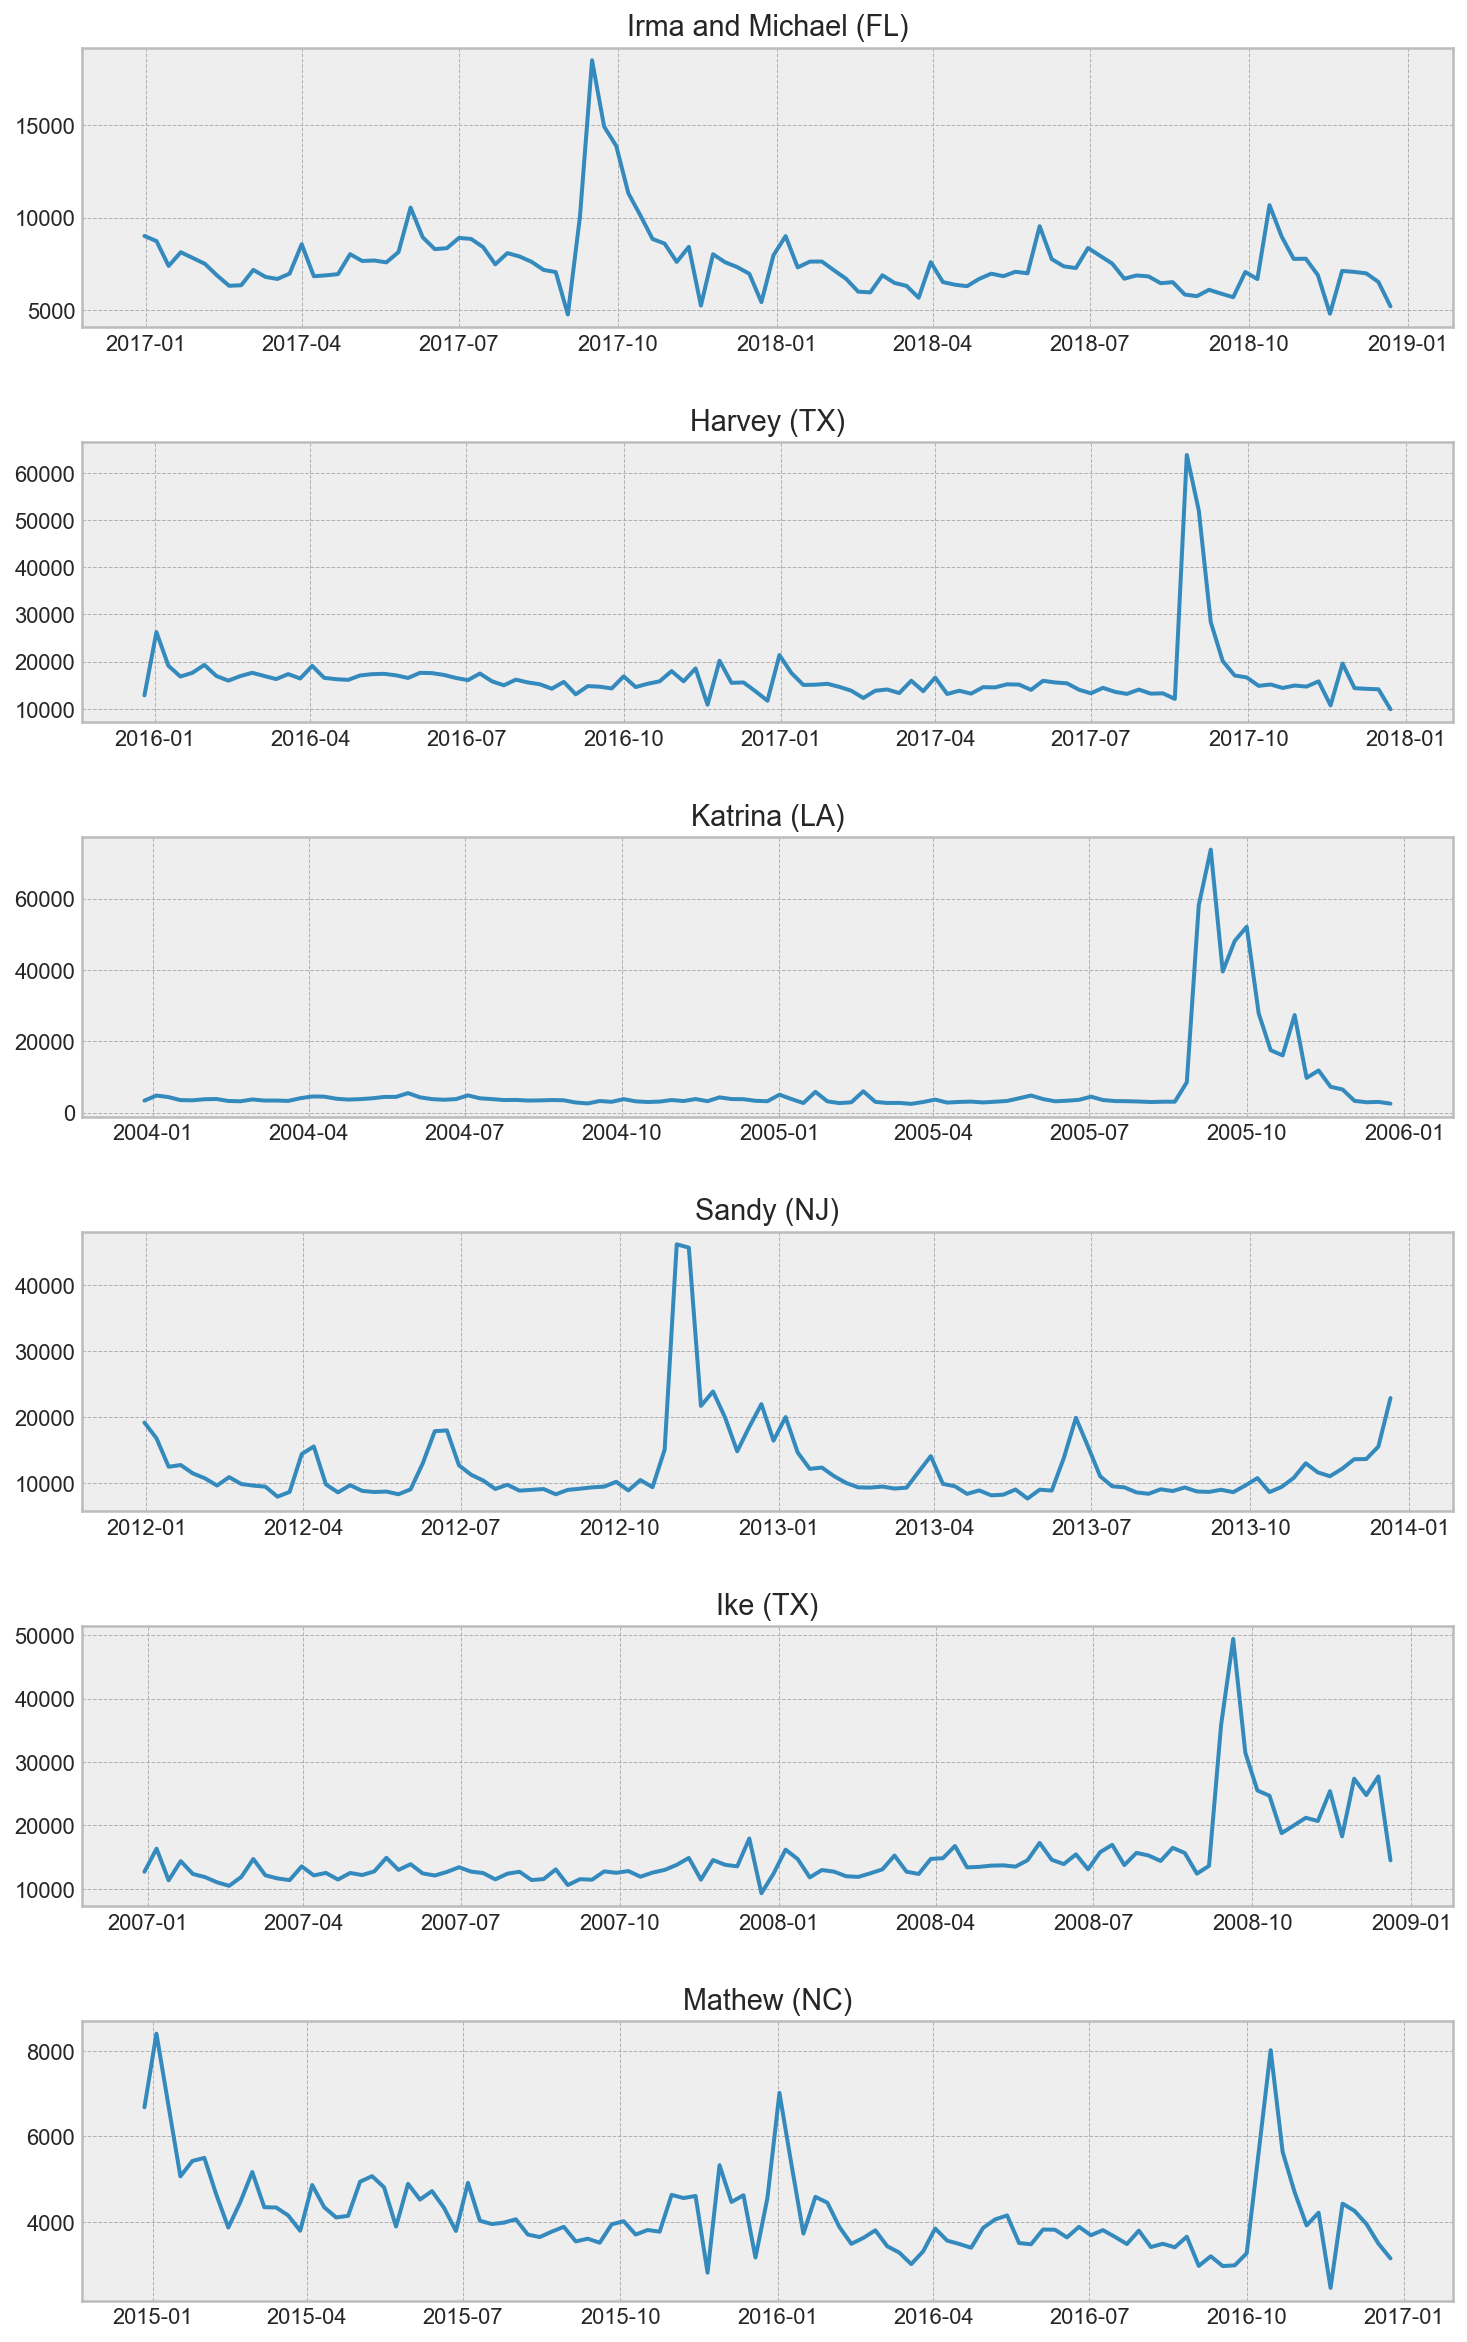

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(11, 17))
plt.style.use('bmh')
plt.tight_layout(pad=4)

ax[0].plot(michael['Initial Claims']);
ax[0].title.set_text('Irma and Michael (FL)')

ax[1].plot(harvey['Initial Claims']);
ax[1].title.set_text('Harvey (TX)')

ax[2].plot(katrina['Initial Claims']);
ax[2].title.set_text('Katrina (LA)')

ax[3].plot(sandy['Initial Claims']);
ax[3].title.set_text('Sandy (NJ)')

ax[4].plot(ike['Initial Claims']);
ax[4].title.set_text('Ike (TX)')

ax[5].plot(mathew['Initial Claims']);
ax[5].title.set_text('Mathew (NC)')

## Calculate delta unemployment claims for all hurricanes

In [15]:
# name = []
# state = []
# category = []
# num_weeks = []
# fema_duration = []
# working_pop = []
# avg_wage = []
# unemp_claims = []

In [16]:
name = []
state = []
num_weeks = []
unemp_claims = []

In [17]:
x = pd.DataFrame(np.array([['KATRINA','LA'],['IRMA','FL'],['HARVEY','TX'],['MICHAEL','FL'],['SANDY','NJ'],['IKE','TX'],['MATTHEW','NC']]))

## Irma

In [18]:
# manually find the index for the week where claims spike
irma.index[89]

Timestamp('2017-09-09 00:00:00')

In [19]:
start_week = 89
stop_week = start_week + 6

# grab the quarterly average for the period right before the hurricane 
# multiply by 6 and compare to the 6 weeks during the disaster
claims_before = irma.resample('QS').mean()['Initial Claims'][6]*6

# isolate the sum of 6 weeks of claims starting with the first pre hurricane spike
claims_after = irma.iloc[start_week:stop_week]['Initial Claims'].sum()

total_claims_irma = claims_after - claims_before

In [20]:
# category_irma = 5
# duration_irma = 15 #DAYS
# pop_irma = 140927392
# wage_irma = 24

#### update columns

In [21]:
# name.append('Irma')
# category.append(5)
# num_weeks.append(6)
# duration.append()
# working_pop.append()
# avg_wage.append()
# unemp_claims.append(total_claims_irma)

In [22]:
name.append('IRMA')
state.append('FL')
num_weeks.append(6)
unemp_claims.append(total_claims_irma)

## Harvey

In [23]:
# manually find the index for the week where claims spike
harvey.index[87]

Timestamp('2017-08-26 00:00:00')

In [24]:
start_week = 87
stop_week = start_week + 6

claims_before = harvey.resample('QS').mean()['Initial Claims'][6]*6
claims_after = harvey.iloc[start_week:stop_week]['Initial Claims'].sum()

total_claims_harvey = claims_after - claims_before

In [25]:
# category_harvey = 4
# duration_harvey = 4 #DAYS
# pop_harvey = 13758050
# wage_harvey = 29

In [26]:
# name.append('Harvey')
# category.append(category_harvey)
# duration.append(duration_harvey)
# working_pop.append(pop_harvey)
# avg_wage.append(wage_harvey)
# unemp_claims.append(total_claims_harvey)

In [27]:
name.append('HARVEY')
state.append('TX')
num_weeks.append(6)
unemp_claims.append(total_claims_harvey)

## Katrina

In [28]:
# manually find the index for the week where claims spike
katrina.index[88]

Timestamp('2005-09-03 00:00:00')

In [29]:
start_week = 88
stop_week = start_week + 13

claims_before = katrina.resample('QS').mean()['Initial Claims'][6]*13
claims_after = katrina.iloc[start_week:stop_week]['Initial Claims'].sum()

total_claims_katrina = claims_after - claims_before

In [30]:
# category_katrina = 3
# duration_katrina = 48 #DAYS
# pop_katrina = fema.loc[fema['s;lfjasdlfkja']]a;lsdfslfd[]a;lsfjasld'fj]pwrjfpirgjx.,nbm.]'.sum()
# wage_katrina = 0

In [31]:
# name.append('Katrina-Rita')
# category.append(category_katrina)
# duration.append(duration_katrina)
# working_pop.append(pop_katrina)
# avg_wage.append(wage_katrina)
# unemp_claims.append(total_claims_katrina)

In [32]:
name.append('KATRINA')
state.append('LA')
num_weeks.append(13)
unemp_claims.append(total_claims_katrina)

## Sandy

In [33]:
# manually find the index for the week where claims spike
sandy.index[54]

Timestamp('2013-01-12 00:00:00')

In [34]:
start_week = 43
stop_week = start_week + 12

claims_before = sandy.resample('QS').mean()['Initial Claims'][2:4].mean()*12
claims_after = sandy.iloc[start_week:stop_week]['Initial Claims'].sum()

total_claims_sandy = claims_after - claims_before

In [35]:
# name.append('Sandy')
# category.append(0)
# duration.append(0)
# working_pop.append(0)
# avg_wage.append(0)
# unemp_claims.append(total_claims_sandy)

In [36]:
name.append('SANDY')
state.append('NJ')
num_weeks.append(12)
unemp_claims.append(total_claims_sandy)

## Ike

In [37]:
ike.index[89]

Timestamp('2008-09-13 00:00:00')

In [38]:
start_week = 89
stop_week = start_week + 14

claims_before = ike.resample('QS').mean()['Initial Claims'][6]*14
claims_after = ike.iloc[start_week:stop_week]['Initial Claims'].sum()

total_claims_ike = claims_after - claims_before

In [39]:
# name.append('Ike')
# category.append(0)
# duration.append(0)
# working_pop.append(0)
# avg_wage.append(0)
# unemp_claims.append(total_claims_ike)

In [40]:
name.append('IKE')
state.append('TX')
num_weeks.append(14)
unemp_claims.append(total_claims_ike)

## Mathew

In [41]:
mathew.index[93]

Timestamp('2016-10-08 00:00:00')

In [42]:
start_week = 93
stop_week = start_week + 5

claims_before = mathew.resample('QS').mean()['Initial Claims'][6]*5
claims_after = mathew.iloc[start_week:stop_week]['Initial Claims'].sum()

total_claims_mathew = claims_after - claims_before

In [43]:
# name.append('Mathew')
# category.append(0)
# duration.append(0)
# working_pop.append(0)
# avg_wage.append(0)
# unemp_claims.append(total_claims_mathew)

In [44]:
name.append('MATHEW')
state.append('NC')
num_weeks.append(5)
unemp_claims.append(total_claims_mathew)

## Michael

In [45]:
michael.index[92]

Timestamp('2018-10-06 00:00:00')

In [46]:
start_week = 92
stop_week = start_week + 6

claims_before = michael.resample('QS').mean()['Initial Claims'][7]*6
claims_after = michael.iloc[start_week:stop_week]['Initial Claims'].sum()

total_claims_michael = claims_after - claims_before

In [47]:
# name.append('Michael')
# category.append(0)
# duration.append(0)
# working_pop.append(0)
# avg_wage.append(0)
# unemp_claims.append(total_claims_michael)

In [48]:
name.append('MICHAEL')
state.append('FL')
num_weeks.append(6)
unemp_claims.append(total_claims_michael)

### Make DF and Train, Test, Split

In [49]:
hurricanes = {'name': name, 
              'state': state,
              'num_weeks': num_weeks,
              'unemp_claims': unemp_claims}

In [50]:
canes = pd.DataFrame(hurricanes)

In [51]:
canes

,name,state,num_weeks,unemp_claims
0,IRMA,FL,6,30502.923077
1,HARVEY,TX,6,109723.230769
2,KATRINA,LA,13,351290.000000
3,SANDY,NJ,12,153312.538462
4,IKE,TX,14,168605.230769
5,MATHEW,NC,5,9262.307692
6,MICHAEL,FL,6,9449.923077


In [52]:
hurricane_traits

,Title,state,Disaster Number,Disaster Type,Incident Begin Date,Incident Duration Days,employed,avg_wage_per_hour
0,KATRINA,LA,1603.0,DR,2005-08-29,64,1981792.0,43.87
1,IRMA,FL,4337.0,DR,2017-09-04,44,24120143.0,50.79
2,HARVEY,TX,4332.0,DR,2017-08-23,23,19167763.0,47.96
3,MICHAEL,FL,4399.0,DR,2018-10-07,12,7202641.0,50.79
4,SANDY,NJ,4086.0,DR,2012-10-26,13,7299609.0,74.85
5,IKE,TX,1791.0,DR,2008-09-07,25,16337336.0,47.96
6,MATTHEW,NC,4285.0,DR,2016-10-04,20,10152014.0,49.32


In [53]:
master = pd.merge(left=hurricane_traits, right=canes, left_on='Title', right_on='name').drop(columns=['state_y', 'name', 'Disaster Type'])

In [54]:
master

,Title,state_x,Disaster Number,Incident Begin Date,Incident Duration Days,employed,avg_wage_per_hour,num_weeks,unemp_claims
0,KATRINA,LA,1603.0,2005-08-29,64,1981792.0,43.87,13,351290.000000
1,IRMA,FL,4337.0,2017-09-04,44,24120143.0,50.79,6,30502.923077
2,HARVEY,TX,4332.0,2017-08-23,23,19167763.0,47.96,6,109723.230769
3,MICHAEL,FL,4399.0,2018-10-07,12,7202641.0,50.79,6,9449.923077
4,SANDY,NJ,4086.0,2012-10-26,13,7299609.0,74.85,12,153312.538462
5,IKE,TX,1791.0,2008-09-07,25,16337336.0,47.96,14,168605.230769


## Export Training table to be used in the modeling notebook

In [62]:
master.to_csv('../Datasets/master_hurricane_list.csv')

## Run a Linear Regression

In [55]:
master.dtypes

Title                      object
state_x                    object
Disaster Number           float64
Incident Begin Date        object
Incident Duration Days      int64
employed                  float64
avg_wage_per_hour         float64
num_weeks                   int64
unemp_claims              float64
dtype: object

In [56]:
X = master[['Incident Duration Days', 'employed', 'avg_wage_per_hour', 'num_weeks']]
y = master['unemp_claims']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

In [58]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
lr.score(X_train, y_train)a

1.0

In [60]:
lr.score(X_test, y_test, )

-6580.682528975661

In [61]:
X_test

,Incident Duration Days,employed,avg_wage_per_hour,num_weeks
4,13,7299609.0,74.85,12
5,25,16337336.0,47.96,14
